This notebook can be run on mybinder: [![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/git/https%3A%2F%2Fgricad-gitlab.univ-grenoble-alpes.fr%2Fchatelaf%2Fml-sicom3a/master?urlpath=lab/tree/notebooks/4_discriminant_analysis/)

# Handwritten digits recognition

We aim to recognize handwritten digits in digital images.
After normalization (see [here](http://statweb.stanford.edu/~tibs/ElemStatLearn/datasets/zip.info.txt) for more details on these data, which are taken from zip codes on US postal envelopes), the resulting images are composed of $16 \times 16$ pixels, each pixel being quantified in gray levels in the interval $[- 1.1]$.
Thus, we  have $X \in [-1,1]^{256}$, i.e $p = 256$, and $Y \in \{0,1, \ldots, 9 \}$.

## Part I

In a fisrt time, we have a training set of $n=257$ samples  (file `zip_train.mat`),  and a test set  of $255$ samples (file `zip_test.mat`).
The code cells below allow to
- [Display some images from each class](#Display-some-digits)
- [Compare several discriminant analysis models and perform a Linear Discriminant Analysis on the training set under the Naïve Bayes assumption (diagonal covariance matrix)](#Compare-the-performances-obtained-for-different-variants-of-discriminant-analysis)
- [Display as an image the estimated mean values for each class $k=0, \ldots, 9$](#Display-as-an-image-the-estimated-mean-values-for-each-class)
- [Display some image realizations according to the generative model that has been learned](#Display-some-image-realizations-according-to-the-generative-model-that-has-been-learned)


### Load data sets

In [1]:
# Import modules
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import scipy.io as spio

# Warning: put the data files in the notebook directory
data = spio.loadmat("zip_train.mat")
Xtrain = data["Xtrain"]
Ytrain = data["Ytrain"]
Xshape = Xtrain.shape
Ytrain = np.reshape(Ytrain, (Xshape[0],))
Yshape = Ytrain.shape

print("Xtrain is (n={},p={}) sized".format(Xshape[0], Xshape[1]))
print("Ytrain is a (n={},) sized vector of reponses".format(Yshape[0]))

data_test = spio.loadmat("zip_test.mat")
Xtest = data_test["Xtest"]
Ytest = data_test["Ytest"]
Ytest = np.reshape(Ytest, (Xtest.shape[0],))
print("Xtest is (n={},p={}) sized".format(Xtest.shape[0], Xtest.shape[1]))

Xtrain is (n=257,p=256) sized
Ytrain is a (n=257,) sized vector of reponses
Xtest is (n=255,p=256) sized


### Display some digits

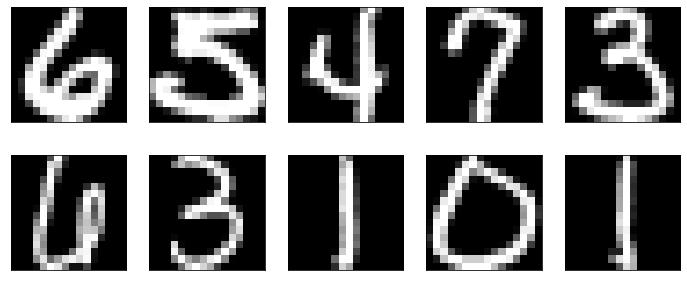

In [2]:
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
for i in range(10):
    fig.add_subplot(2, 5, i+1)
    mplot = plt.imshow(np.reshape(Xtrain[i], (16, 16)), cmap="gray")
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)

### Compare the performances obtained for different variants of discriminant analysis

- We already know that LDA and QDA methods are already coded in scikit-learn through [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) and  [QuadraticDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis.html#sklearn.discriminant_analysis.QuadraticDiscriminantAnalysis).
- Moreover, QDA with Naïve Bayes is available with [GaussianNB](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)
- Last, LDA with Naïve Bayes can be obtained as a special case of the [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis) method when the shrinkage parameter equals 1 (`shrinkage=1`)



In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from sklearn.naive_bayes import GaussianNB as QDA_NB


def print_discr_analysis_perf(model, msg):
    # train the discr_analysis model
    model.fit(Xtrain, Ytrain)
    # compute the train/test misclassification rates (mcr)
    Ytrain_hat = model.predict(Xtrain)
    mcr_train = np.mean(Ytrain_hat != Ytrain)
    Ytest_hat = model.predict(Xtest)
    mcr_test = np.mean(Ytest_hat != Ytest)
    print("{:7s} misclassification rates: train = {:0.3f}, test = {:0.3f}".
          format(msg, mcr_train, mcr_test))


# QDA case
print_discr_analysis_perf(QDA(), 'QDA')
# QDA + NB case
print_discr_analysis_perf(QDA_NB(), 'QDA+NB')
# LDA case
print_discr_analysis_perf(LDA(), 'LDA')
# LDA + NB case
print_discr_analysis_perf(LDA(solver="eigen", shrinkage=1), 'LDA+NB')

QDA     misclassification rates: train = 0.000, test = 0.827
QDA+NB  misclassification rates: train = 0.125, test = 0.451
LDA     misclassification rates: train = 0.000, test = 0.710
LDA+NB  misclassification rates: train = 0.136, test = 0.259


/home/chatelaf/miniconda3/envs/calc/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


#### Exercise I.1:
- Can you explain why sklearn algo raises a warning when we train the QDA and LDA models (and not in the QDA+NB and LDA+NB case)?
- How to justify that the linear discriminant analysis under the Naïve Bayes assumption seems the most appropriate among all the methods of discriminant analysis?

### Display as an image the estimated mean values for each class 
Wee focus now on the LDA with *NB assumption* (i.e., same *diagonal* covariance matrix for all the classes) classifier

In [4]:
# Train LDA + NB
lda_nb = LDA(solver="eigen",  shrinkage=1)
lda_nb.fit(Xtrain, Ytrain)

LinearDiscriminantAnalysis(shrinkage=1, solver='eigen')

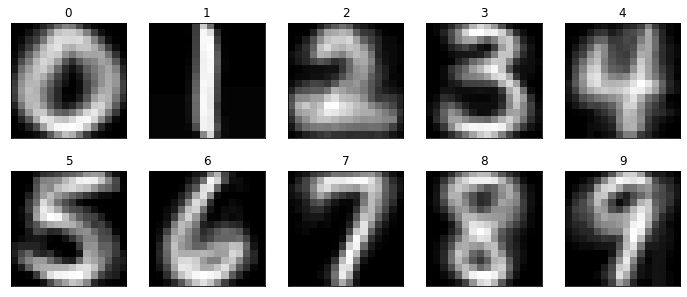

In [5]:
# this show the mean vector of the LDA classes
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
for k in range(0, 10):
    fig.add_subplot(2, 5, k+1)
    Xmean = lda_nb.means_[k]
    mplot = plt.imshow(np.reshape(Xmean, (16, 16)), cmap="gray")
    plt.title(k)
    # hide the axis
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)
plt.show()

### Display some image realizations according to the generative model that has been learned

Draw some Gaussian vectors according to the LDA with NB model


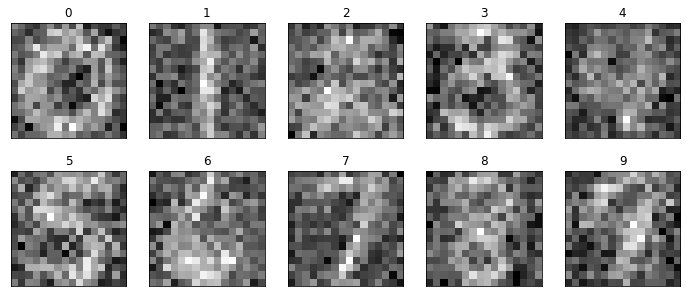

In [6]:
print('Draw some Gaussian vectors according to the LDA with NB model')
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
for k in range(0, 10):
    fig.add_subplot(2, 5, k+1)
    # generate the gaussian vector
    Xsynth = lda_nb.means_[k] + \
        np.real(sp.linalg.sqrtm(lda_nb.covariance_)) @ np.random.randn(256)
    mplot = plt.imshow(np.reshape(Xsynth, (16, 16)), cmap="gray")
    plt.title(k)
    # hide the axis
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)
plt.show()

#### Exercise I.2:
Run several times the cells above and below to observe different random realizations
- Do these synthetic examples seem realistic to you? 
- What is the interest of such a model?
- Comparing with QDA based synthetic examples on the cell below, what can we conclude (remember that QDA obtains here catastrophic generalization performances on test data)?

#### Synthetic examples for QDA: display some image realizations based on the QDA generative model

/home/chatelaf/miniconda3/envs/calc/lib/python3.7/site-packages/sklearn/discriminant_analysis.py:715: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


Draw some Gaussian vectors according to the QDA model


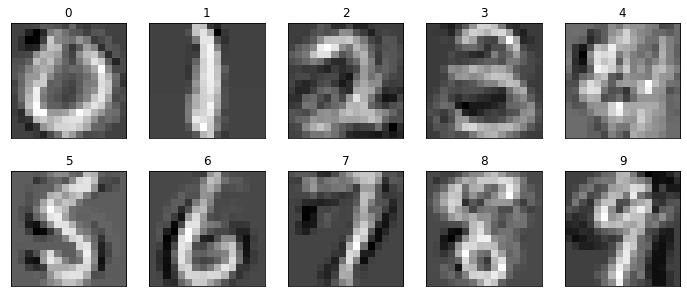

In [7]:
qda = QDA(store_covariance=True)
qda.fit(Xtrain, Ytrain)

print('Draw some Gaussian vectors according to the QDA model')
fig = plt.figure(figsize=(12, 5))  # to specify the size of the images
for k in range(0, 10):
    fig.add_subplot(2, 5, k+1)
    # generate the gaussian vector
    Xsynth = qda.means_[k] + \
        np.real(sp.linalg.sqrtm(qda.covariance_[k])) @ np.random.randn(256)
    mplot = plt.imshow(np.reshape(Xsynth, (16, 16)), cmap="gray")
    plt.title(k)
    # hide the axis
    mplot.axes.get_xaxis().set_visible(False)
    mplot.axes.get_yaxis().set_visible(False)
plt.show()

## Part 2:  Regularized discriminant analysis

To obtain more flexibility for LDA methods, a common procedure is regularized (linear) discriminant analysis:  all classes have the same covariance matrix

$
\hat{\Sigma}_\gamma = (1-\gamma) \hat{\Sigma} + \gamma \mathrm{diag}{(\hat{\Sigma})},
$

where $\hat{\Sigma}$ is the empirical pooled covariance matrix, $\mathrm{diag}{(\hat{\Sigma})}$ is the diagonal matrix with diagonal entries equal to those of $\hat{\Sigma}$ (Naïve Bayes empirical estimate), and $\gamma \in [0,1]$ is the amount of regularization.

Within sklearn, the regularization coefficient $\gamma$ correponds to the `shrinkage` parameter of    [LinearDiscriminantAnalysis](https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html#sklearn.discriminant_analysis.LinearDiscriminantAnalysis).


The code cells below allow to
- [Display misclassification rate curves as a function of the regularizion coefficient](#Display-misclassification-rate-curves-as-a-function-of-the-regularized-discriminant-analysis-coefficient-%24%5Cgamma%24)
- [Estimate the optimal parameter $\gamma$ in an automatic way](#Automatic-estimation-of-the-optimal-regularization-parameter-$\gamma$)
- [Train LDA on a larger dataset](#Dealing-with-larger-datasets)
- [Display the confusion matrix to see the most common errors](#Display-the-confusion-matrix)


### Display misclassification rate curves as a function of the regularized discriminant analysis coefficient $\gamma$

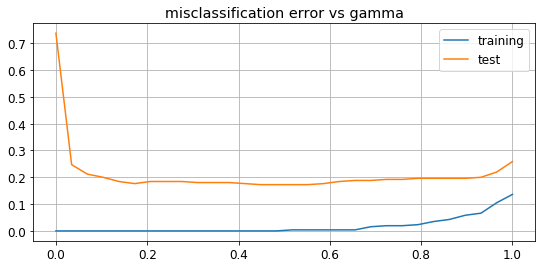

In [8]:
res = 30  # you can crank up the resolution but it will not change a lot
gamma = np.linspace(1e-6, 1, res) # array of regularization coefficients
mcr_test = np.zeros(res)
mcr_train = np.zeros(res)

for i in range(res):
    lda_reg = LDA(solver='lsqr', shrinkage=gamma[i])
    lda_reg.fit(Xtrain, Ytrain)

    yhat_train = lda_reg.predict(Xtrain)
    mcr_train[i] = np.mean(Ytrain != yhat_train)

    yhat_test = lda_reg.predict(Xtest)
    mcr_test[i] = np.mean(Ytest != yhat_test)

plt.figure(figsize=(9, 4))
plt.rc('font', size=12)
plt.plot(gamma, mcr_train, label="training")
plt.plot(gamma, mcr_test, label="test")
plt.legend()
plt.title("misclassification error vs gamma")
plt.grid()
plt.show()

In [9]:
# Tune hyperparameter gamma
ihat = np.argmin(mcr_test)
gamhat = gamma[ihat]
mcr_opt = mcr_test[ihat]
print('optimal value for gamma: {}'.format(gamhat))
print('misclassification rate for best gamma parameter: {}'.format(mcr_opt))

optimal value for gamma: 0.4482764137931034
misclassification rate for best gamma parameter: 0.17254901960784313


#### Exercise II.1: 
- Explain what happens in the limiting case $\gamma=0$ or $\gamma=1$? And which methods correspond to these particular cases of regularized discriminant analysis?
- What are a good choices here for the $\gamma$ values?
- In practice, when there is no test set, which common procedure can we use to estimate the optimal value of $\gamma$? (note: we will see below a performant and cost-efficient alternative)
- (*Optional*) Compare with the performance/computational cost  obtained for a k-NN classifier

### Automatic estimation of the optimal regularization parameter $\gamma$

In the high dimensional framework, i.e. large dimension $p$ and large sample size $n$, this becomes possible to estimate the optimal shrinkage parameter (which minimizes the Frobenius norm $||\Sigma-\widehat{\Sigma}_\gamma||$) in a **simple analytic way** following the result introduced in
 > Ledoit O, Wolf M. *Honey, I Shrunk the Sample Covariance Matrix*. The Journal of Portfolio Management 30(4), 110-119, 2004.

With sklearn, this can be used by setting the shrinkage parameter of the `LinearDiscriminantAnalysis` class to ‘auto’, i.e. ```shrinkage='auto'```. 

In [10]:
lda_auto = LDA(solver="eigen", shrinkage="auto")
lda_auto.fit(Xtrain, Ytrain)

y_hat = lda_auto.predict(Xtrain)
mcr_train = np.mean(Ytrain != y_hat)

y_hat = lda_auto.predict(Xtest)
mcr_test = np.mean(Ytest != y_hat)

print("Auto regularized LDA mcr: train = {:0.3f}, test = {:0.3f}".
          format(mcr_train, mcr_test))

Auto regularized LDA mcr: train = 0.008, test = 0.188


#### Exercise II.2:
- Is this in good agreement with the estimates of the optimal regularized LDA perfomance derived previously?
- What are the benefits of this 'automatic' method compare to cross-validation?

### Dealing with larger datasets
We consider now the larger datasets `Xtrain_full`  (Matlab file `zip_train_full.mat`) and `Xtest_full` (`zip_test_full.mat`):

In [11]:
# Warning: put the data files in the notebook directory
data = spio.loadmat("zip_train_full.mat")
Xtrain_full = data["Xtrain_full"]
Ytrain_full = data["Ytrain_full"]
Xshape = Xtrain_full.shape
Ytrain_full = np.reshape(Ytrain_full, (Xshape[0],))
Yshape = Ytrain_full.shape

print("Xtrain_full is (n={},p={}) sized".format(Xshape[0], Xshape[1]))
print("Ytrain_full is a (n={},) sized vector of reponses".format(Yshape[0]))

data_test = spio.loadmat("zip_test_full.mat")
Xtest_full = data_test["Xtest_full"]
Ytest_full = data_test["Ytest_full"]
Ytest_full = np.reshape(Ytest_full, (Xtest_full.shape[0],))
print("Xtest is (n={},p={}) sized".format(Xtest_full.shape[0], Xtest_full.shape[1]))

Xtrain_full is (n=8250,p=256) sized
Ytrain_full is a (n=8250,) sized vector of reponses
Xtest is (n=2750,p=256) sized


#### Exercise II.3:
- Apply (see below) regularized LDA to these larger datasets and compare the performances with the previous one. What can you conclude?
- Compare now the optimal values for the regularization parameter $\gamma$. How to explain this?
- (*Optional*) Compare now with a regularized QDA (set the `reg_param` parameter). How to explain this?
- (*Optional*) Compare with the the performance/cost ratio obtained for a k-NN classifier

Auto regularized LDA mcr: train = 0.079, test = 0.101


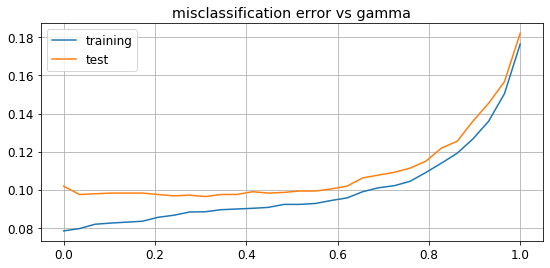

In [12]:
lda_auto = LDA(solver="eigen", shrinkage="auto")
lda_auto.fit(Xtrain_full, Ytrain_full)

y_hat = lda_auto.predict(Xtrain_full)
mcr_train = np.mean(Ytrain_full != y_hat)

y_hat = lda_auto.predict(Xtest_full)
mcr_test = np.mean(Ytest_full != y_hat)

print("Auto regularized LDA mcr: train = {:0.3f}, test = {:0.3f}".
          format(mcr_train, mcr_test))

res = 30  # you can crank up the resolution but it will not change a lot
gamma = np.linspace(1e-6, 1, res) # array of regularization coefficients
mcr_test = np.zeros(res)
mcr_train = np.zeros(res)

for i in range(res):
    lda_reg = LDA(solver='lsqr', shrinkage=gamma[i])
    lda_reg.fit(Xtrain_full, Ytrain_full)

    yhat_train = lda_reg.predict(Xtrain_full)
    mcr_train[i] = np.mean(Ytrain_full != yhat_train)

    yhat_test = lda_reg.predict(Xtest_full)
    mcr_test[i] = np.mean(Ytest_full != yhat_test)

plt.figure(figsize=(9, 4))
plt.rc('font', size=12)
plt.plot(gamma, mcr_train, label="training")
plt.plot(gamma, mcr_test, label="test")
plt.legend()
plt.title("misclassification error vs gamma")
plt.grid()
plt.show()

### Display the *confusion matrix*

The *confusion matrix* (see the [scikitlearn user guide](https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix) for some examples) is a useful tool in supervised learning to evaluate classification accuracy. Quoting Wikipedia:
>Each column of the matrix represents the instances in a predicted class while each row represents the instances in an actual class (or vice versa, depending on the convention). The name stems from the fact that it makes it easy to see the confusion between two classes (i.e. commonly mislabeling one as another). 

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(Ytest_full, y_hat) # y_hat is the auto regularized LDA prediction

array([[258,   2,   3,   1,   0,   3,   6,   0,   2,   0],
       [  1, 257,   0,   2,   4,   0,   0,   0,  11,   0],
       [  3,   7, 235,   3,   3,   4,   6,   6,   6,   2],
       [  4,   1,   6, 250,   0,   7,   1,   4,   1,   1],
       [  0,  10,   3,   0, 238,   0,   3,   1,   1,  19],
       [  3,   2,   1,  21,   2, 240,   1,   2,   2,   1],
       [  5,   5,   3,   0,   1,   2, 258,   0,   1,   0],
       [  0,   3,   0,   0,   2,   1,   0, 254,   2,  13],
       [  6,   7,   1,   6,   2,  14,   0,   0, 232,   7],
       [  0,   6,   0,   0,   8,   0,   0,   8,   2, 251]])

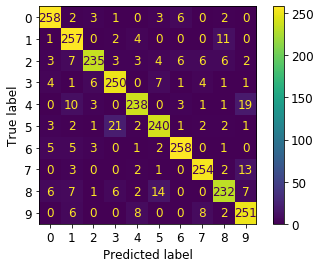

In [14]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(lda_auto, Xtest_full, Ytest_full)
plt.show() 

#### Exercise II.4:
- What are the the most common confusions between classes?